# Math

## 1 Connection of directed graphs

- (Original version) kNN graphs: $i^t\rightarrow j^{t+1}$ if node $i$ is one of the $k$-nearest neighbors of $j$. *Note: asymmetric*

- (Simplified version) line graph: $i^t\rightarrow i^{t+1}$ for each $i, t$. For a line graph, its regularized Laplacian matrix $\mathbf{L}^d_r=\begin{bmatrix} 0\\ -1 & 1\\ & -1 & 1\\ & &\ddots &\ddots\\& & &-1 & 1\end{bmatrix}$
  $$
  (\mathbf{L}^d_r\mathbf{x})_{i,t} = \left\{
  \begin{aligned}
  &0 , && t=0\\
  &x_{i, t} - x_{i, t-1}, && t > 0
  \end{aligned}
  \right.,\quad ((\mathbf{L}^d_r)^\top\mathbf{x})_{i,t} = \left\{
  \begin{aligned}
  &-x_{i, t+1} , && t=0\\
  &x_{i, t} - x_{i, t+1}, && 0<t < T-1\\
  & x_{i, t}, && t=T-1
  \end{aligned}
  \right.
  $$
  

## 2 GLR for fully-undirected graph

Only change directed graph into undirected graph, denote the original undirected graph on $T$ time frames as $\mathbf{L}^u$,  denote undirected cross-time connection as $\mathbf{L}^n$.

- Line graph, compute regularized version:
  $$
  \mathbf{L}^n = \begin{bmatrix}
  1 & -\frac{1}{\sqrt{2}}\\
  -\frac{1}{\sqrt{2}} & 1 & -\frac{1}{\sqrt{2}}\\
  & -\frac{1}{\sqrt{2}} & 1 & \ddots\\
  & &\ddots & \ddots &-\frac{1}{\sqrt{2}}\\
  & & & -\frac{1}{\sqrt{2}} & 1
  \end{bmatrix}, (\mathbf{L}^n\mathbf{x})_{i,t} = x_{i,t} - \frac{1}{\sqrt{2}}(x_{i, t+1} + x_{i, t-1})
  $$
  

- kNN graph, compute *unregularized* version:
  $$
  (\mathbf{Lx})_i = [(\mathbf{D} - \mathbf{W})\mathbf{x}]_i = d_ix_i - \sum_j w_{ij}x_j=\sum_{(i,j)\in\mathcal{E}}w_{ij}(x_i - x_j)
  $$
  for kNN graph, compute its father features and children features separately:
  $$
  (\mathbf{L}^u\mathbf{x})_{i,t} = \sum_k w_{k,i}^{t-1, t} (x_{i, t} - x_{k, t-1}) + \sum_j w_{i,j}^{t-1, t} (x_{i, t} - x_{j, t+1})
  $$

In [2]:
# import
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np 
from utils import *
from ADMM import *

# 1 Load data

1. prediction: `x = data[0:24], y = data[0:12]`
2. difference: `dx[t] = x[t+1] - x[t]`
3. interpolation: `x = data[0:24], y = x * mask`. Mask rate 0.4, set to `NaN`

In [3]:
# dataset
data_dir = '../datasets/PEMS0X_data'
# TODO: change here
dataset = 'PEMS08'
data_folder = os.path.join(data_dir, dataset)
data_file = dataset + '.npz'
graph_csv = dataset + '.csv'
# data
traffic_dataset = TrafficDataset(data_folder, data_file, graph_csv)
print(f"data shape: {traffic_dataset.data.shape}, node number: {traffic_dataset.graph_info['n_nodes']}, edge number: {traffic_dataset.graph_info['n_edges']}")

# kNNs and graph construction
k = 4
nearest_nodes, nearest_dists = k_nearest_neighbors(traffic_dataset.graph_info['n_nodes'], traffic_dataset.graph_info['u_edges'], traffic_dataset.graph_info['u_dist'], k)
print(f'nearest nodes: {nearest_nodes.shape}, nearest_dists: {nearest_dists.shape}')

# mixed_graph_from_distance()

x, y = traffic_dataset.get_predict_data(0)
x, y = x.unsqueeze(0), y.unsqueeze(0)
print(f'recovering: x: {x.shape}, y: {y.shape}')

# difference in data
diff_x, diff_y = get_data_difference(x), get_data_difference(y)
print(f'difference: x: {diff_x.shape}, y: {diff_y.shape}')

# interpolation
interp_x, interp_y, mask = traffic_dataset.get_interpolated_data(0, 0.4)
interp_x, interp_y, mask = interp_x.unsqueeze(0), interp_y.unsqueeze(0), mask.unsqueeze(0)
print(f'interpolation: x: {interp_x.shape}, y: {interp_y.shape}, mask: {mask.shape}')

data shape: torch.Size([17856, 170, 1]), node number: 170, edge number: 295
170 nodes, 4 neighbors
nearest nodes: torch.Size([170, 5]), nearest_dists: torch.Size([170, 5])
recovering: x: torch.Size([1, 24, 170, 1]), y: torch.Size([1, 12, 170, 1])
difference: x: torch.Size([1, 23, 170, 1]), y: torch.Size([1, 11, 170, 1])
interpolation: x: torch.Size([1, 24, 170, 1]), y: torch.Size([1, 24, 170, 1]), mask: torch.Size([1, 24, 170, 1])


# 2 Regression

Test regression result for neighbor of one node
- prediction
- difference
- interpolation

torch.Size([1, 24, 5, 1])


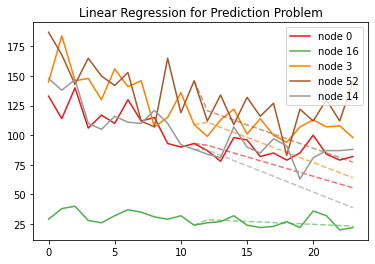

Linear regression: w torch.Size([1, 5, 1]), b torch.Size([1, 5, 1])
torch.Size([1, 24, 5, 1])


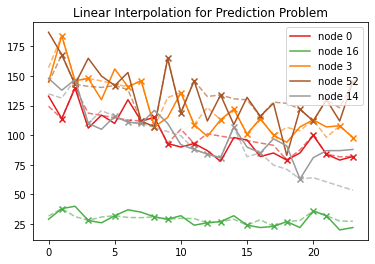

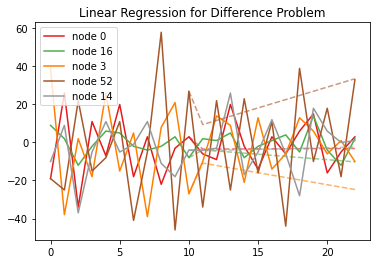

torch.Size([1, 24, 5, 1])


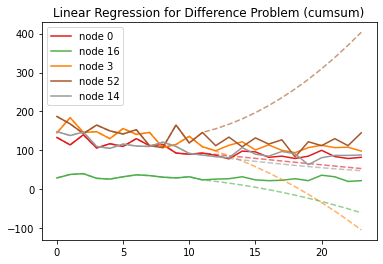

In [4]:
# take node 0 as an example
knn = nearest_nodes[0].to(torch.long) # [0. 92, 117, 173, 243]
# prediction
x_data = x[:,:,knn]
y_data = y[:,:,knn]
diff_x_data = diff_x[:,:,knn]
diff_y_data = diff_y[:,:,knn]
interp_x_data = interp_x[:,:,knn]
interp_y_data = interp_y[:,:,knn]
mask_data = mask[:,:,knn]

# linear regression
lr_y = initial_guess(y_data, 12, 24)
print(lr_y.shape)
t = torch.arange(0, 24, 1)
colors = plt.cm.Set1(np.linspace(0, 1, 5))

plt.figure()
for i, color in enumerate(colors):
    plt.plot(t, x_data.squeeze()[:,i], color=color, label=f'node {knn[i]}')
    plt.plot(t[11:], lr_y.squeeze()[11:,i], color=color, linestyle='--', alpha=0.6)
# plt.legend([f'node {i}' for i in knn])
plt.legend()
plt.title('Linear Regression for Prediction Problem')
plt.show()

# interpolation
lr_interp_y = initial_interpolation(interp_y_data, mask_data)
print(lr_interp_y.shape)
plt.figure()
for i, color in enumerate(colors):
    plt.plot(t, x_data.squeeze()[:,i], color=color, label=f'node {knn[i]}')
    plt.plot(t, lr_interp_y.squeeze()[:,i], color=color, linestyle='--', alpha=0.6)
    mask_i = mask_data.squeeze()[:,i].bool()

    # x_mask_i = x_data.squeeze()[mask.squeeze()[:,i] == 1, i]
    plt.scatter(t[mask_i], x_data.squeeze()[:,i][mask_i], color=color, marker='x')
# plt.legend([f'node {i}' for i in knn])
plt.legend()
plt.title('Linear Interpolation for Prediction Problem')
plt.show()

# difference
lr_diff_y = initial_guess(diff_y_data, 11, 23)
# t = torch.arange(0, 23, 1)
plt.figure()
for i, color in enumerate(colors):
    # plt.plot(t, x_data.squeeze()[:,i], color=color, label=f'node {knn[i]}')
    # plt.plot(t[11:], cumsum_y.squeeze()[11:,i], color=color, linestyle='--', alpha=0.6)
    plt.plot(t[:-1], diff_x_data.squeeze()[:,i], color=color, label=f'node {knn[i]}')
    plt.plot(t[10:-1], lr_diff_y.squeeze()[10:,i], color=color, linestyle='--', alpha=0.6)

plt.legend()
plt.title('Linear Regression for Difference Problem')
plt.show()

plt.figure()

# sum up
cumsum_y = torch.cumsum(lr_diff_y, dim=1) + y_data[:,:1]
cumsum_y = torch.cat((y_data[:,0:1], cumsum_y), dim=1)
print(cumsum_y.shape)
for i, color in enumerate(colors):
    # plt.plot(t, x_data.squeeze()[:,i], color=color, label=f'node {knn[i]}')
    # plt.plot(t[11:], cumsum_y.squeeze()[11:,i], color=color, linestyle='--', alpha=0.6)
    plt.plot(t, x_data.squeeze()[:,i], color=color, label=f'node {knn[i]}')
    plt.plot(t, cumsum_y.squeeze()[:,i], color=color, linestyle='--', alpha=0.6)

plt.legend()
plt.title('Linear Regression for Difference Problem (cumsum)')
plt.show()


# 3 ADMM algorithm

different graph types:
- undirected graph: kNN graph based on distance on each layer
- directed graphs:
    - kNN graphs
    - line graphs

different data types:
- prediction
- interpolation
- difference

ablation studies:
- w/o DGTV
- w/o DGLR
- fully undirected graph

## 3.1 Prediction problems
- with directed graph as kNN graph
- directed graph as line graph

rho_init: 2.661453237111885
170 nodes, 4 neighbors
Undirected graph: sigma = 50, nearest_dist in (6.3000, 1557.9000)
Directed Graph: sigma = 50, nearest_dist in (6.3000, 1557.9000)
u_ew, d_ew shape torch.Size([24, 170, 4]) torch.Size([23, 170, 5])
ADMM iters 0: x_CG_iters 14, zu_CG_iters 12, zd_CG_iters 17, pri_err = [750.8, 22.51, 213.9], dual_err = [751.1, 22.52, 213.9]
ADMM iters 1: x_CG_iters 20, zu_CG_iters 11, zd_CG_iters 17, pri_err = [32.5, 6.391, 52.5], dual_err = [97.91, 259.3, 796.7]
ADMM iters 2: x_CG_iters 19, zu_CG_iters 12, zd_CG_iters 17, pri_err = [92.44, 6.153, 22.42], dual_err = [275.9, 118.9, 335.2]
ADMM iters 3: x_CG_iters 19, zu_CG_iters 12, zd_CG_iters 17, pri_err = [81.21, 5.897, 25.75], dual_err = [245.1, 81.87, 235.5]
ADMM iters 4: x_CG_iters 19, zu_CG_iters 12, zd_CG_iters 17, pri_err = [64.21, 4.767, 27.16], dual_err = [201.5, 60.12, 188.3]
ADMM iters 5: x_CG_iters 18, zu_CG_iters 11, zd_CG_iters 17, pri_err = [50.15, 4.99, 24.81], dual_err = [165.6, 44.73, 

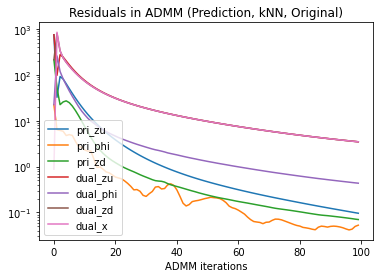

c:\Users\qij21\Desktop\test\ADMM-demo\ADMM.py:531: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:210.)
  dxps = torch.tensor([item.cpu().detach().numpy() for item in self.delta_x_per_step]) # in (L, 24)


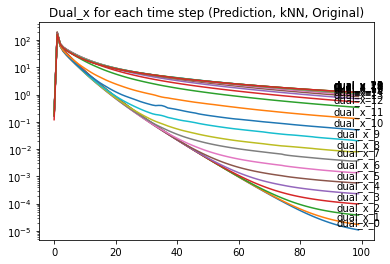

In [5]:
import math
rho_init = math.sqrt(traffic_dataset.graph_info['n_nodes'] / 24)
mu_init = 1
print('rho_init:', rho_init)
ADMM_info = {
    'rho': rho_init * 2,
    'rho_u': rho_init * 3,
    'rho_d': rho_init * 2,
    'mu_u': mu_init,
    'mu_d1':mu_init * 2,
    'mu_d2': mu_init
}
admm_block = ADMM_algorithm(traffic_dataset.graph_info,
                            ADMM_info,
                            use_kNN=True,
                            k=4,
                            u_sigma=50,
                            d_sigma=50,
                            )
x_pred = admm_block.combined_loop(y)
admm_block.plot_residual(descriptions='Prediction, kNN, Original', log_y=True)
admm_block.plot_x_per_step(descriptions='Prediction, kNN, Original', log_y=True)

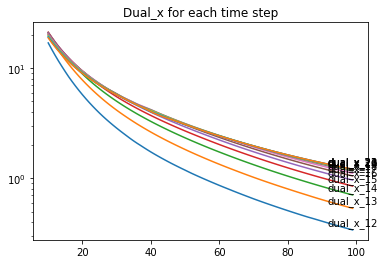

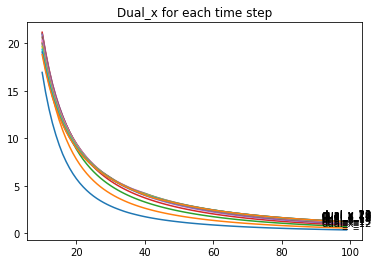

In [6]:
admm_block.plot_x_per_step(show_list=range(12, 24), start_iters=10, log_y=True)
admm_block.plot_x_per_step(show_list=range(12, 24), start_iters=10, log_y=False)
# admm_block.plot_CG_params()

rho_init: 2.661453237111885
170 nodes, 4 neighbors
Undirected graph: sigma = 50, nearest_dist in (6.3000, 1557.9000)
u_ew, d_ew shape torch.Size([24, 170, 4]) torch.Size([23, 170, 1])
ADMM iters 0: x_CG_iters 14, zu_CG_iters 12, zd_CG_iters 17, pri_err = [750.8, 21.96, 188.9], dual_err = [751.1, 21.97, 188.9]
ADMM iters 1: x_CG_iters 19, zu_CG_iters 11, zd_CG_iters 17, pri_err = [26.25, 6.681, 48.51], dual_err = [86, 175.4, 826.6]
ADMM iters 2: x_CG_iters 18, zu_CG_iters 12, zd_CG_iters 16, pri_err = [92.19, 5.531, 13.46], dual_err = [275.1, 101, 334.6]
ADMM iters 3: x_CG_iters 18, zu_CG_iters 12, zd_CG_iters 17, pri_err = [81.24, 5.553, 23.56], dual_err = [244.9, 70.6, 233.4]
ADMM iters 4: x_CG_iters 18, zu_CG_iters 12, zd_CG_iters 16, pri_err = [64.19, 4.945, 27.08], dual_err = [201.3, 51.08, 187.1]
ADMM iters 5: x_CG_iters 17, zu_CG_iters 11, zd_CG_iters 16, pri_err = [50.14, 3.962, 25.27], dual_err = [165.5, 37.52, 154.9]
ADMM iters 6: x_CG_iters 17, zu_CG_iters 11, zd_CG_iters 16,

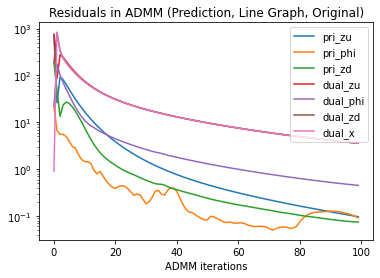

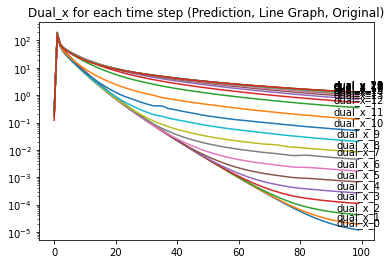

In [7]:
import math
rho_init = math.sqrt(traffic_dataset.graph_info['n_nodes'] / 24)
mu_init = 1
print('rho_init:', rho_init)
ADMM_info = {
    'rho': rho_init * 2,
    'rho_u': rho_init * 3,
    'rho_d': rho_init * 2,
    'mu_u': mu_init,
    'mu_d1':mu_init * 2,
    'mu_d2': mu_init
}
admm_block = ADMM_algorithm(traffic_dataset.graph_info,
                            ADMM_info,
                            use_kNN=True,
                            k=4,
                            u_sigma=50,
                            d_sigma=50,
                            use_line_graph=True
                            )
x_pred = admm_block.combined_loop(y)
admm_block.plot_residual(descriptions='Prediction, Line Graph, Original', log_y=True)
admm_block.plot_x_per_step(descriptions='Prediction, Line Graph, Original', log_y=True)
# admm_block.plot_CG_params()

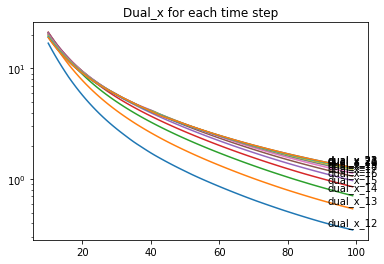

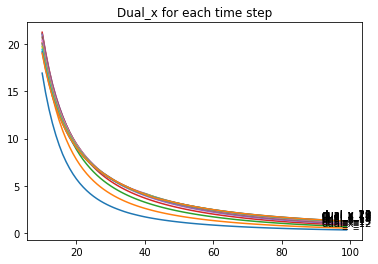

In [8]:
admm_block.plot_x_per_step(show_list=range(12, 24), start_iters=10, log_y=True)
admm_block.plot_x_per_step(show_list=range(12, 24), start_iters=10, log_y=False)

## 3.2 Interpolation Problems
- directed graphs as kNN graphs
- directed graphs as line graphs

rho_init: 2.661453237111885
170 nodes, 4 neighbors
Undirected graph: sigma = 50, nearest_dist in (6.3000, 1557.9000)
Directed Graph: sigma = 50, nearest_dist in (6.3000, 1557.9000)
u_ew, d_ew shape torch.Size([24, 170, 4]) torch.Size([23, 170, 5])
Linear regression: w torch.Size([1, 170, 1]), b torch.Size([1, 170, 1])
ADMM iters 0: x_CG_iters 14, zu_CG_iters 12, zd_CG_iters 17, pri_err = [755.7, 22.87, 222], dual_err = [756, 22.87, 222]
ADMM iters 1: x_CG_iters 20, zu_CG_iters 11, zd_CG_iters 17, pri_err = [32.78, 7.161, 52.38], dual_err = [101.6, 273.3, 801.6]
ADMM iters 2: x_CG_iters 19, zu_CG_iters 12, zd_CG_iters 17, pri_err = [88.11, 8.152, 25.88], dual_err = [271.2, 127.9, 327.1]
ADMM iters 3: x_CG_iters 19, zu_CG_iters 12, zd_CG_iters 17, pri_err = [76.85, 8.615, 32.73], dual_err = [239.4, 92.39, 229]
ADMM iters 4: x_CG_iters 19, zu_CG_iters 12, zd_CG_iters 17, pri_err = [60.41, 8.444, 35.12], dual_err = [195.4, 71.64, 182.2]
ADMM iters 5: x_CG_iters 19, zu_CG_iters 11, zd_CG_it

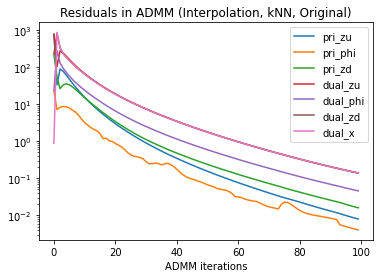

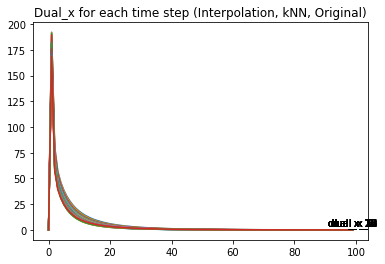

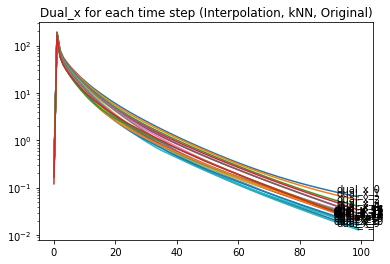

In [9]:
import math
rho_init = math.sqrt(traffic_dataset.graph_info['n_nodes'] / 24)
mu_init = 1
print('rho_init:', rho_init)
ADMM_info = {
    'rho': rho_init * 2,
    'rho_u': rho_init * 3,
    'rho_d': rho_init * 2,
    'mu_u': mu_init,
    'mu_d1':mu_init * 2,
    'mu_d2': mu_init
}
admm_block = ADMM_algorithm(traffic_dataset.graph_info,
                            ADMM_info,
                            use_kNN=True,
                            k=4,
                            u_sigma=50,
                            d_sigma=50,
                            )
x_interp = admm_block.combined_loop(interp_y, mask=mask)
admm_block.plot_residual(descriptions='Interpolation, kNN, Original', log_y=True)
admm_block.plot_x_per_step(descriptions='Interpolation, kNN, Original', log_y=False)
admm_block.plot_x_per_step(descriptions='Interpolation, kNN, Original', log_y=True)

rho_init: 2.661453237111885
170 nodes, 4 neighbors
Undirected graph: sigma = 50, nearest_dist in (6.3000, 1557.9000)
u_ew, d_ew shape torch.Size([24, 170, 4]) torch.Size([23, 170, 1])
Linear regression: w torch.Size([1, 170, 1]), b torch.Size([1, 170, 1])
ADMM iters 0: x_CG_iters 14, zu_CG_iters 12, zd_CG_iters 17, pri_err = [755.7, 22.6, 197.5], dual_err = [756, 22.61, 197.5]
ADMM iters 1: x_CG_iters 19, zu_CG_iters 11, zd_CG_iters 17, pri_err = [26.33, 7.468, 47.82], dual_err = [90.23, 190.3, 833.1]
ADMM iters 2: x_CG_iters 18, zu_CG_iters 12, zd_CG_iters 17, pri_err = [87.78, 8.73, 18.79], dual_err = [270.6, 114, 326]
ADMM iters 3: x_CG_iters 18, zu_CG_iters 12, zd_CG_iters 17, pri_err = [76.64, 9.81, 31.64], dual_err = [238.9, 84.52, 226.5]
ADMM iters 4: x_CG_iters 18, zu_CG_iters 12, zd_CG_iters 17, pri_err = [60.11, 9.217, 35.56], dual_err = [194.7, 65.85, 180.6]
ADMM iters 5: x_CG_iters 18, zu_CG_iters 11, zd_CG_iters 17, pri_err = [46.65, 8.121, 33.79], dual_err = [158.5, 52.59

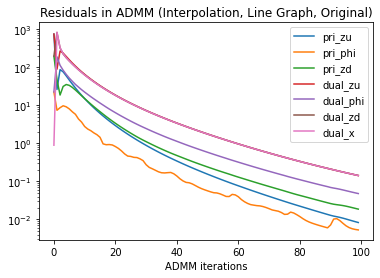

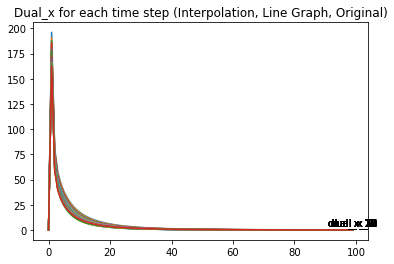

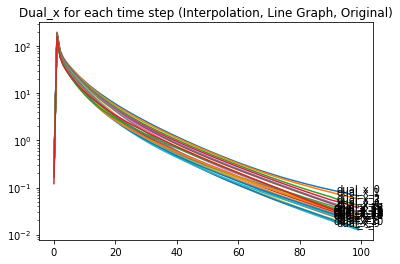

In [10]:
# line graph
import math
rho_init = math.sqrt(traffic_dataset.graph_info['n_nodes'] / 24)
mu_init = 1
print('rho_init:', rho_init)
ADMM_info = {
    'rho': rho_init * 2,
    'rho_u': rho_init * 3,
    'rho_d': rho_init * 2,
    'mu_u': mu_init,
    'mu_d1':mu_init * 2,
    'mu_d2': mu_init
}
admm_block = ADMM_algorithm(traffic_dataset.graph_info,
                            ADMM_info,
                            use_kNN=True,
                            k=4,
                            u_sigma=50,
                            d_sigma=50,
                            use_line_graph=True
                            )
x_interp = admm_block.combined_loop(interp_y, mask=mask)
admm_block.plot_residual(descriptions='Interpolation, Line Graph, Original', log_y=True)
admm_block.plot_x_per_step(descriptions='Interpolation, Line Graph, Original', log_y=False)
admm_block.plot_x_per_step(descriptions='Interpolation, Line Graph, Original', log_y=True)

## 3.3 Ablation Studies

### 3.3.1 Undirected graphs
- with **line graph**
- with **kNN graph**

rho_init: 2.661453237111885
170 nodes, 4 neighbors
Undirected graph: sigma = 50, nearest_dist in (6.3000, 1557.9000)
u_ew, d_ew shape torch.Size([24, 170, 4]) torch.Size([23, 170, 1])
Linear regression: w torch.Size([1, 170, 1]), b torch.Size([1, 170, 1])
ADMM iters 0: x_CG_iters 2, zu_CG_iters 12, zd_CG_iters 17, pri_err = [755.7, 197.5], dual_err = [756, 197.5]
ADMM iters 1: x_CG_iters 2, zu_CG_iters 12, zd_CG_iters 17, pri_err = [42.59, 30.7], dual_err = [148.4, 833.5]
ADMM iters 2: x_CG_iters 2, zu_CG_iters 12, zd_CG_iters 17, pri_err = [88.15, 38.17], dual_err = [273.5, 327.4]
ADMM iters 3: x_CG_iters 2, zu_CG_iters 12, zd_CG_iters 17, pri_err = [76.58, 40.98], dual_err = [239.6, 229.2]
ADMM iters 4: x_CG_iters 2, zu_CG_iters 12, zd_CG_iters 17, pri_err = [60.18, 36.25], dual_err = [195.4, 182.7]
ADMM iters 5: x_CG_iters 2, zu_CG_iters 11, zd_CG_iters 17, pri_err = [46.84, 30], dual_err = [159.4, 149.7]
ADMM iters 6: x_CG_iters 2, zu_CG_iters 11, zd_CG_iters 17, pri_err = [36.67, 

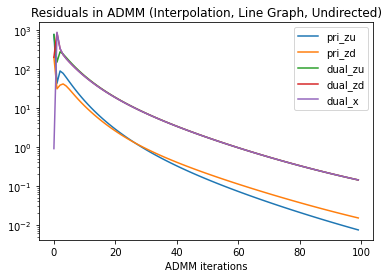

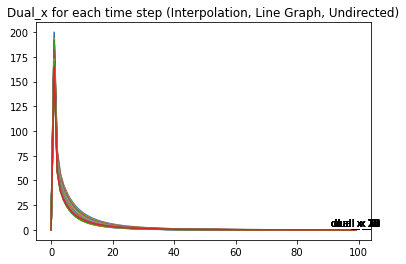

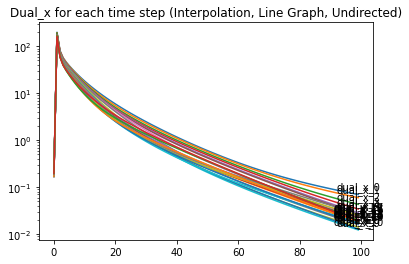

In [11]:
import math
rho_init = math.sqrt(traffic_dataset.graph_info['n_nodes'] / 24)
mu_init = 1
print('rho_init:', rho_init)
ADMM_info = {
    'rho': rho_init * 2,
    'rho_u': rho_init * 3,
    'rho_d': rho_init * 2,
    'mu_u': mu_init,
    'mu_d1':mu_init * 2,
    'mu_d2': mu_init
}
admm_block = ADMM_algorithm(traffic_dataset.graph_info,
                            ADMM_info,
                            use_kNN=True,
                            k=4,
                            u_sigma=50,
                            d_sigma=50,
                            use_line_graph=True,
                            ablation='UT'
                            )
x_interp = admm_block.combined_loop(interp_y, mask=mask)
admm_block.plot_residual(descriptions='Interpolation, Line Graph, Undirected', log_y=True)
admm_block.plot_x_per_step(descriptions='Interpolation, Line Graph, Undirected', log_y=False)
admm_block.plot_x_per_step(descriptions='Interpolation, Line Graph, Undirected', log_y=True)

rho_init: 2.661453237111885
170 nodes, 4 neighbors
Undirected graph: sigma = 50, nearest_dist in (6.3000, 1557.9000)
Directed Graph: sigma = 50, nearest_dist in (6.3000, 1557.9000)
u_ew, d_ew shape torch.Size([24, 170, 4]) torch.Size([23, 170, 5])
Linear regression: w torch.Size([1, 170, 1]), b torch.Size([1, 170, 1])
ADMM iters 0: x_CG_iters 2, zu_CG_iters 12, zd_CG_iters 17, pri_err = [755.7, 222], dual_err = [756, 222]
ADMM iters 1: x_CG_iters 2, zu_CG_iters 12, zd_CG_iters 17, pri_err = [53.46, 44.8], dual_err = [166.8, 812.8]
ADMM iters 2: x_CG_iters 2, zu_CG_iters 12, zd_CG_iters 17, pri_err = [88.94, 40.83], dual_err = [275.3, 327.4]
ADMM iters 3: x_CG_iters 2, zu_CG_iters 12, zd_CG_iters 17, pri_err = [76.37, 41.51], dual_err = [239.5, 230.2]
ADMM iters 4: x_CG_iters 2, zu_CG_iters 12, zd_CG_iters 17, pri_err = [59.78, 36.31], dual_err = [194.9, 183]
ADMM iters 5: x_CG_iters 2, zu_CG_iters 11, zd_CG_iters 17, pri_err = [46.39, 29.93], dual_err = [158.9, 149.7]
ADMM iters 6: x_C

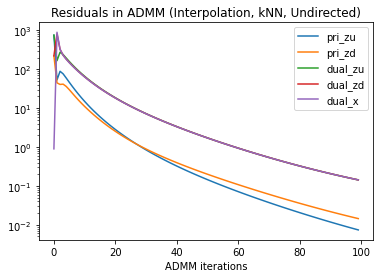

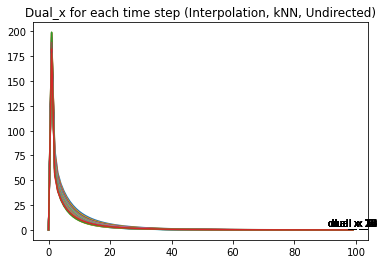

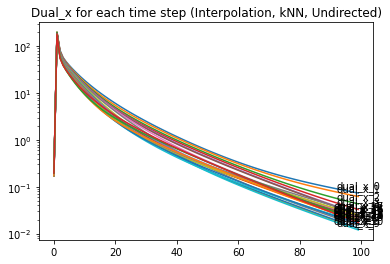

In [12]:
import math
rho_init = math.sqrt(traffic_dataset.graph_info['n_nodes'] / 24)
mu_init = 1
print('rho_init:', rho_init)
ADMM_info = {
    'rho': rho_init * 2,
    'rho_u': rho_init * 3,
    'rho_d': rho_init * 2,
    'mu_u': mu_init,
    'mu_d1':mu_init * 2,
    'mu_d2': mu_init
}
admm_block = ADMM_algorithm(traffic_dataset.graph_info,
                            ADMM_info,
                            use_kNN=True,
                            k=4,
                            u_sigma=50,
                            d_sigma=50,
                            use_line_graph=False,
                            ablation='UT'
                            )
x_interp = admm_block.combined_loop(interp_y, mask=mask)
admm_block.plot_residual(descriptions='Interpolation, kNN, Undirected', log_y=True)
admm_block.plot_x_per_step(descriptions='Interpolation, kNN, Undirected', log_y=False)
admm_block.plot_x_per_step(descriptions='Interpolation, kNN, Undirected', log_y=True)

rho_init: 2.661453237111885
170 nodes, 4 neighbors
Undirected graph: sigma = 50, nearest_dist in (6.3000, 1557.9000)
u_ew, d_ew shape torch.Size([24, 170, 4]) torch.Size([23, 170, 1])
ADMM iters 0: x_CG_iters 2, zu_CG_iters 12, zd_CG_iters 17, pri_err = [750.8, 188.9], dual_err = [751.1, 188.9]
ADMM iters 1: x_CG_iters 2, zu_CG_iters 11, zd_CG_iters 17, pri_err = [38.58, 23.99], dual_err = [133.5, 826.7]
ADMM iters 2: x_CG_iters 2, zu_CG_iters 12, zd_CG_iters 17, pri_err = [92.4, 27.21], dual_err = [276.8, 335.5]
ADMM iters 3: x_CG_iters 2, zu_CG_iters 12, zd_CG_iters 17, pri_err = [80.77, 26.42], dual_err = [243.5, 233.8]
ADMM iters 4: x_CG_iters 2, zu_CG_iters 12, zd_CG_iters 16, pri_err = [63.75, 20.37], dual_err = [199.9, 186.6]
ADMM iters 5: x_CG_iters 2, zu_CG_iters 11, zd_CG_iters 16, pri_err = [49.83, 14.1], dual_err = [164.5, 154.1]
ADMM iters 6: x_CG_iters 2, zu_CG_iters 11, zd_CG_iters 16, pri_err = [39.23, 9.361], dual_err = [137.3, 129.5]
ADMM iters 7: x_CG_iters 2, zu_CG_

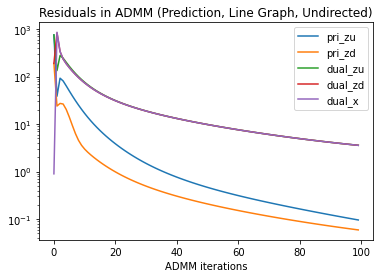

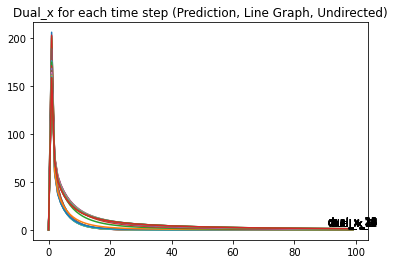

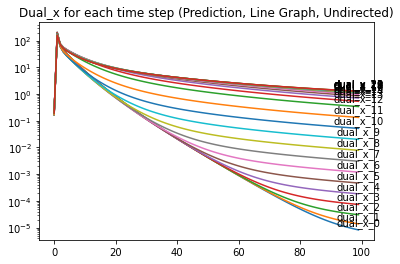

In [13]:
import math
rho_init = math.sqrt(traffic_dataset.graph_info['n_nodes'] / 24)
mu_init = 1
print('rho_init:', rho_init)
ADMM_info = {
    'rho': rho_init * 2,
    'rho_u': rho_init * 3,
    'rho_d': rho_init * 2,
    'mu_u': mu_init,
    'mu_d1':mu_init * 2,
    'mu_d2': mu_init
}
admm_block = ADMM_algorithm(traffic_dataset.graph_info,
                            ADMM_info,
                            use_kNN=True,
                            k=4,
                            u_sigma=50,
                            d_sigma=50,
                            use_line_graph=True,
                            ablation='UT'
                            )
x_pred = admm_block.combined_loop(y)
admm_block.plot_residual(descriptions='Prediction, Line Graph, Undirected', log_y=True)
admm_block.plot_x_per_step(descriptions='Prediction, Line Graph, Undirected', log_y=False)
admm_block.plot_x_per_step(descriptions='Prediction, Line Graph, Undirected', log_y=True)

rho_init: 2.661453237111885
170 nodes, 4 neighbors
Undirected graph: sigma = 50, nearest_dist in (6.3000, 1557.9000)
Directed Graph: sigma = 50, nearest_dist in (6.3000, 1557.9000)
u_ew, d_ew shape torch.Size([24, 170, 4]) torch.Size([23, 170, 5])
ADMM iters 0: x_CG_iters 2, zu_CG_iters 12, zd_CG_iters 17, pri_err = [750.8, 213.9], dual_err = [751.1, 213.9]
ADMM iters 1: x_CG_iters 2, zu_CG_iters 12, zd_CG_iters 17, pri_err = [50.27, 40.21], dual_err = [153.6, 807]
ADMM iters 2: x_CG_iters 2, zu_CG_iters 12, zd_CG_iters 17, pri_err = [93.45, 31.44], dual_err = [278.9, 335.7]
ADMM iters 3: x_CG_iters 2, zu_CG_iters 12, zd_CG_iters 17, pri_err = [80.49, 27.9], dual_err = [243.4, 234.6]
ADMM iters 4: x_CG_iters 2, zu_CG_iters 12, zd_CG_iters 17, pri_err = [63.17, 21.26], dual_err = [199.2, 186.7]
ADMM iters 5: x_CG_iters 2, zu_CG_iters 11, zd_CG_iters 16, pri_err = [49.15, 14.85], dual_err = [163.6, 153.7]
ADMM iters 6: x_CG_iters 2, zu_CG_iters 11, zd_CG_iters 16, pri_err = [38.54, 10.06

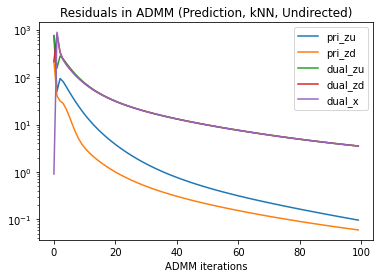

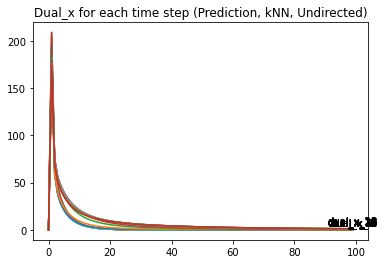

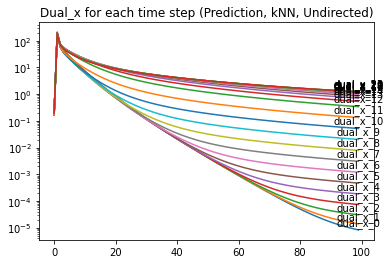

In [14]:
import math
rho_init = math.sqrt(traffic_dataset.graph_info['n_nodes'] / 24)
mu_init = 1
print('rho_init:', rho_init)
ADMM_info = {
    'rho': rho_init * 2,
    'rho_u': rho_init * 3,
    'rho_d': rho_init * 2,
    'mu_u': mu_init,
    'mu_d1':mu_init * 2,
    'mu_d2': mu_init
}
admm_block = ADMM_algorithm(traffic_dataset.graph_info,
                            ADMM_info,
                            use_kNN=True,
                            k=4,
                            u_sigma=50,
                            d_sigma=50,
                            use_line_graph=False,
                            ablation='UT'
                            )
x_pred = admm_block.combined_loop(y)
admm_block.plot_residual(descriptions='Prediction, kNN, Undirected', log_y=True)
admm_block.plot_x_per_step(descriptions='Prediction, kNN, Undirected', log_y=False)
admm_block.plot_x_per_step(descriptions='Prediction, kNN, Undirected', log_y=True)

### 3.3.2 w/o DGTV
Remove DGTV term for kNN graph and line graph

rho_init: 2.661453237111885
170 nodes, 4 neighbors
Undirected graph: sigma = 50, nearest_dist in (6.3000, 1557.9000)
u_ew, d_ew shape torch.Size([24, 170, 4]) torch.Size([23, 170, 1])
Linear regression: w torch.Size([1, 170, 1]), b torch.Size([1, 170, 1])
ADMM iters 0: x_CG_iters 2, zu_CG_iters 12, zd_CG_iters 17, pri_err = [755.7, 197.5], dual_err = [756, 197.5]
ADMM iters 1: x_CG_iters 2, zu_CG_iters 12, zd_CG_iters 17, pri_err = [42.59, 30.7], dual_err = [148.4, 833.5]
ADMM iters 2: x_CG_iters 2, zu_CG_iters 12, zd_CG_iters 17, pri_err = [88.15, 38.17], dual_err = [273.5, 327.4]
ADMM iters 3: x_CG_iters 2, zu_CG_iters 12, zd_CG_iters 17, pri_err = [76.58, 40.98], dual_err = [239.6, 229.2]
ADMM iters 4: x_CG_iters 2, zu_CG_iters 12, zd_CG_iters 17, pri_err = [60.18, 36.25], dual_err = [195.4, 182.7]
ADMM iters 5: x_CG_iters 2, zu_CG_iters 11, zd_CG_iters 17, pri_err = [46.84, 30], dual_err = [159.4, 149.7]
ADMM iters 6: x_CG_iters 2, zu_CG_iters 11, zd_CG_iters 17, pri_err = [36.67, 

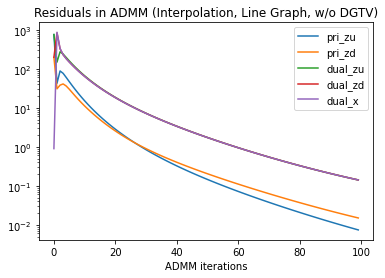

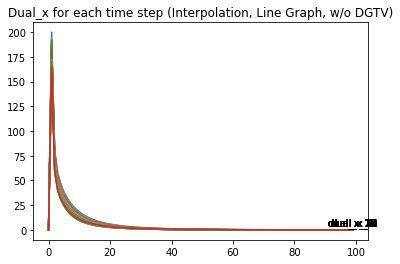

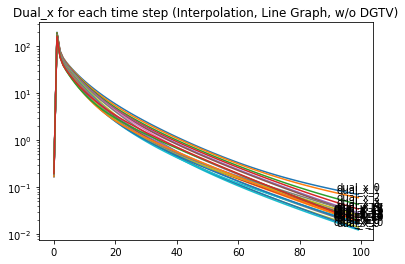

In [15]:
import math
rho_init = math.sqrt(traffic_dataset.graph_info['n_nodes'] / 24)
mu_init = 1
print('rho_init:', rho_init)
ADMM_info = {
    'rho': rho_init * 2,
    'rho_u': rho_init * 3,
    'rho_d': rho_init * 2,
    'mu_u': mu_init,
    'mu_d1':mu_init * 2,
    'mu_d2': mu_init
}
admm_block = ADMM_algorithm(traffic_dataset.graph_info,
                            ADMM_info,
                            use_kNN=True,
                            k=4,
                            u_sigma=50,
                            d_sigma=50,
                            use_line_graph=True,
                            ablation='DGTV'
                            )
x_interp = admm_block.combined_loop(interp_y, mask=mask)
admm_block.plot_residual(descriptions='Interpolation, Line Graph, w/o DGTV', log_y=True)
admm_block.plot_x_per_step(descriptions='Interpolation, Line Graph, w/o DGTV', log_y=False)
admm_block.plot_x_per_step(descriptions='Interpolation, Line Graph, w/o DGTV', log_y=True)

rho_init: 2.661453237111885
170 nodes, 4 neighbors
Undirected graph: sigma = 50, nearest_dist in (6.3000, 1557.9000)
Directed Graph: sigma = 50, nearest_dist in (6.3000, 1557.9000)
u_ew, d_ew shape torch.Size([24, 170, 4]) torch.Size([23, 170, 5])
Linear regression: w torch.Size([1, 170, 1]), b torch.Size([1, 170, 1])
ADMM iters 0: x_CG_iters 2, zu_CG_iters 12, zd_CG_iters 17, pri_err = [755.7, 222], dual_err = [756, 222]
ADMM iters 1: x_CG_iters 2, zu_CG_iters 12, zd_CG_iters 17, pri_err = [53.46, 44.8], dual_err = [166.8, 812.8]
ADMM iters 2: x_CG_iters 2, zu_CG_iters 12, zd_CG_iters 17, pri_err = [88.94, 40.83], dual_err = [275.3, 327.4]
ADMM iters 3: x_CG_iters 2, zu_CG_iters 12, zd_CG_iters 17, pri_err = [76.37, 41.51], dual_err = [239.5, 230.2]
ADMM iters 4: x_CG_iters 2, zu_CG_iters 12, zd_CG_iters 17, pri_err = [59.78, 36.31], dual_err = [194.9, 183]
ADMM iters 5: x_CG_iters 2, zu_CG_iters 11, zd_CG_iters 17, pri_err = [46.39, 29.93], dual_err = [158.9, 149.7]
ADMM iters 6: x_C

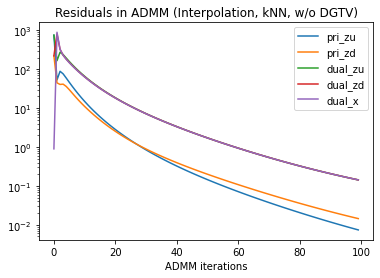

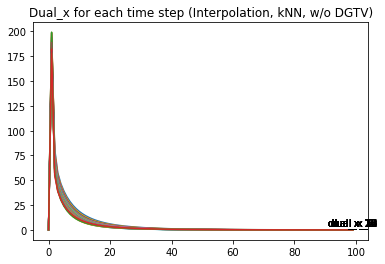

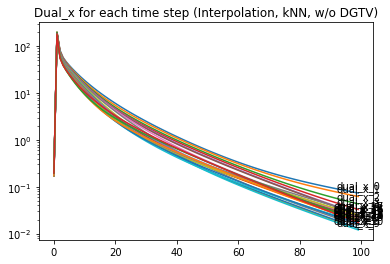

In [16]:
import math
rho_init = math.sqrt(traffic_dataset.graph_info['n_nodes'] / 24)
mu_init = 1
print('rho_init:', rho_init)
ADMM_info = {
    'rho': rho_init * 2,
    'rho_u': rho_init * 3,
    'rho_d': rho_init * 2,
    'mu_u': mu_init,
    'mu_d1':mu_init * 2,
    'mu_d2': mu_init
}
admm_block = ADMM_algorithm(traffic_dataset.graph_info,
                            ADMM_info,
                            use_kNN=True,
                            k=4,
                            u_sigma=50,
                            d_sigma=50,
                            use_line_graph=False,
                            ablation='DGTV'
                            )
x_interp = admm_block.combined_loop(interp_y, mask=mask)
admm_block.plot_residual(descriptions='Interpolation, kNN, w/o DGTV', log_y=True)
admm_block.plot_x_per_step(descriptions='Interpolation, kNN, w/o DGTV', log_y=False)
admm_block.plot_x_per_step(descriptions='Interpolation, kNN, w/o DGTV', log_y=True)

rho_init: 2.661453237111885
170 nodes, 4 neighbors
Undirected graph: sigma = 50, nearest_dist in (6.3000, 1557.9000)
u_ew, d_ew shape torch.Size([24, 170, 4]) torch.Size([23, 170, 1])
ADMM iters 0: x_CG_iters 2, zu_CG_iters 12, zd_CG_iters 17, pri_err = [750.8, 188.9], dual_err = [751.1, 188.9]
ADMM iters 1: x_CG_iters 2, zu_CG_iters 11, zd_CG_iters 17, pri_err = [38.58, 23.99], dual_err = [133.5, 826.7]
ADMM iters 2: x_CG_iters 2, zu_CG_iters 12, zd_CG_iters 17, pri_err = [92.4, 27.21], dual_err = [276.8, 335.5]
ADMM iters 3: x_CG_iters 2, zu_CG_iters 12, zd_CG_iters 17, pri_err = [80.77, 26.42], dual_err = [243.5, 233.8]
ADMM iters 4: x_CG_iters 2, zu_CG_iters 12, zd_CG_iters 16, pri_err = [63.75, 20.37], dual_err = [199.9, 186.6]
ADMM iters 5: x_CG_iters 2, zu_CG_iters 11, zd_CG_iters 16, pri_err = [49.83, 14.1], dual_err = [164.5, 154.1]
ADMM iters 6: x_CG_iters 2, zu_CG_iters 11, zd_CG_iters 16, pri_err = [39.23, 9.361], dual_err = [137.3, 129.5]
ADMM iters 7: x_CG_iters 2, zu_CG_

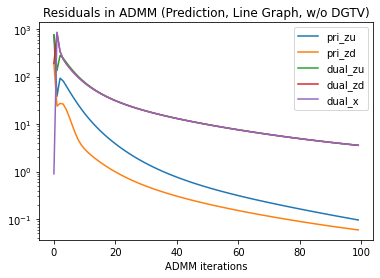

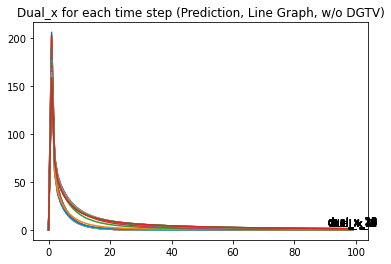

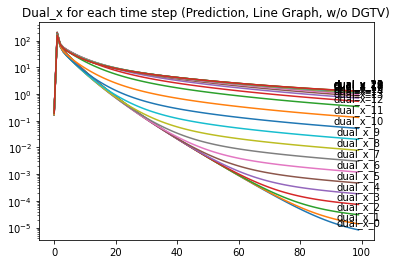

In [17]:
import math
rho_init = math.sqrt(traffic_dataset.graph_info['n_nodes'] / 24)
mu_init = 1
print('rho_init:', rho_init)
ADMM_info = {
    'rho': rho_init * 2,
    'rho_u': rho_init * 3,
    'rho_d': rho_init * 2,
    'mu_u': mu_init,
    'mu_d1':mu_init * 2,
    'mu_d2': mu_init
}
admm_block = ADMM_algorithm(traffic_dataset.graph_info,
                            ADMM_info,
                            use_kNN=True,
                            k=4,
                            u_sigma=50,
                            d_sigma=50,
                            use_line_graph=True,
                            ablation='DGTV'
                            )
x_pred = admm_block.combined_loop(y)
admm_block.plot_residual(descriptions='Prediction, Line Graph, w/o DGTV', log_y=True)
admm_block.plot_x_per_step(descriptions='Prediction, Line Graph, w/o DGTV', log_y=False)
admm_block.plot_x_per_step(descriptions='Prediction, Line Graph, w/o DGTV', log_y=True)

rho_init: 2.661453237111885
170 nodes, 4 neighbors
Undirected graph: sigma = 50, nearest_dist in (6.3000, 1557.9000)
Directed Graph: sigma = 50, nearest_dist in (6.3000, 1557.9000)
u_ew, d_ew shape torch.Size([24, 170, 4]) torch.Size([23, 170, 5])
ADMM iters 0: x_CG_iters 2, zu_CG_iters 12, zd_CG_iters 17, pri_err = [750.8, 213.9], dual_err = [751.1, 213.9]
ADMM iters 1: x_CG_iters 2, zu_CG_iters 12, zd_CG_iters 17, pri_err = [50.27, 40.21], dual_err = [153.6, 807]
ADMM iters 2: x_CG_iters 2, zu_CG_iters 12, zd_CG_iters 17, pri_err = [93.45, 31.44], dual_err = [278.9, 335.7]
ADMM iters 3: x_CG_iters 2, zu_CG_iters 12, zd_CG_iters 17, pri_err = [80.49, 27.9], dual_err = [243.4, 234.6]
ADMM iters 4: x_CG_iters 2, zu_CG_iters 12, zd_CG_iters 17, pri_err = [63.17, 21.26], dual_err = [199.2, 186.7]
ADMM iters 5: x_CG_iters 2, zu_CG_iters 11, zd_CG_iters 16, pri_err = [49.15, 14.85], dual_err = [163.6, 153.7]
ADMM iters 6: x_CG_iters 2, zu_CG_iters 11, zd_CG_iters 16, pri_err = [38.54, 10.06

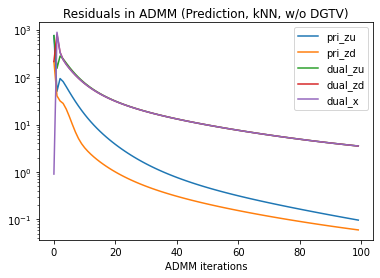

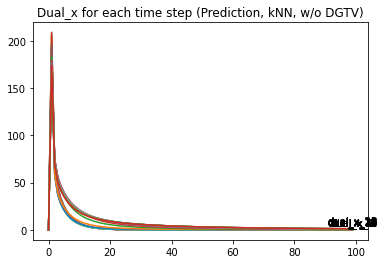

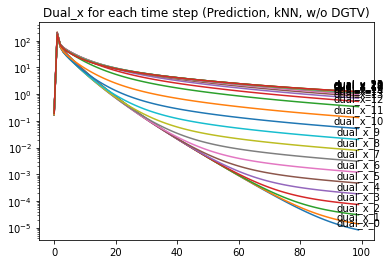

In [18]:
import math
rho_init = math.sqrt(traffic_dataset.graph_info['n_nodes'] / 24)
mu_init = 1
print('rho_init:', rho_init)
ADMM_info = {
    'rho': rho_init * 2,
    'rho_u': rho_init * 3,
    'rho_d': rho_init * 2,
    'mu_u': mu_init,
    'mu_d1':mu_init * 2,
    'mu_d2': mu_init
}
admm_block = ADMM_algorithm(traffic_dataset.graph_info,
                            ADMM_info,
                            use_kNN=True,
                            k=4,
                            u_sigma=50,
                            d_sigma=50,
                            use_line_graph=False,
                            ablation='DGTV'
                            )
x_pred = admm_block.combined_loop(y)
admm_block.plot_residual(descriptions='Prediction, kNN, w/o DGTV', log_y=True)
admm_block.plot_x_per_step(descriptions='Prediction, kNN, w/o DGTV', log_y=False)
admm_block.plot_x_per_step(descriptions='Prediction, kNN, w/o DGTV', log_y=True)

rho_init: 2.661453237111885
170 nodes, 4 neighbors
Undirected graph: sigma = 50, nearest_dist in (6.3000, 1557.9000)
u_ew, d_ew shape torch.Size([23, 170, 4]) torch.Size([22, 170, 1])
ADMM iters 0: x_CG_iters 14, zu_CG_iters 11, zd_CG_iters 17, pri_err = [166.3, 20.95, 300.6], dual_err = [166.2, 20.95, 300.6]
ADMM iters 1: x_CG_iters 18, zu_CG_iters 11, zd_CG_iters 17, pri_err = [10.27, 5.958, 84.56], dual_err = [62.65, 272.7, 143.8]
ADMM iters 2: x_CG_iters 18, zu_CG_iters 11, zd_CG_iters 16, pri_err = [28, 4.509, 17.6], dual_err = [91.54, 162.9, 61.63]
ADMM iters 3: x_CG_iters 18, zu_CG_iters 11, zd_CG_iters 16, pri_err = [24.75, 4.484, 36.18], dual_err = [77.82, 113.5, 53.14]
ADMM iters 4: x_CG_iters 17, zu_CG_iters 11, zd_CG_iters 16, pri_err = [18.97, 3.864, 43.81], dual_err = [60.32, 81.06, 49.72]
ADMM iters 5: x_CG_iters 17, zu_CG_iters 11, zd_CG_iters 16, pri_err = [14.11, 3.505, 41.75], dual_err = [45.93, 57.6, 43.79]
ADMM iters 6: x_CG_iters 17, zu_CG_iters 11, zd_CG_iters 16

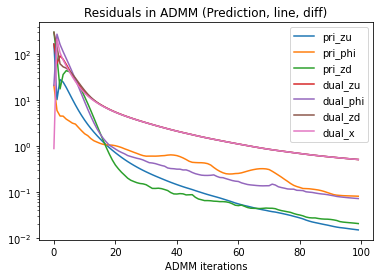

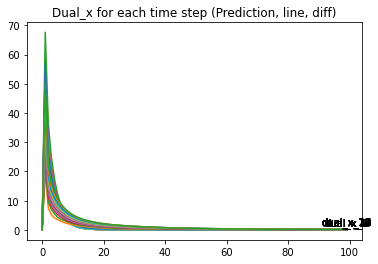

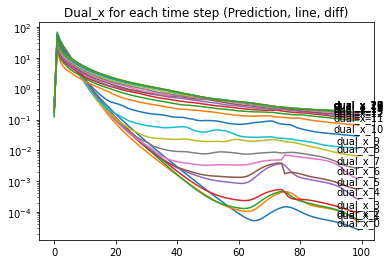

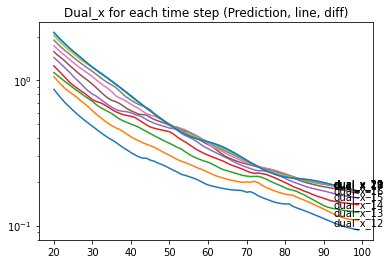

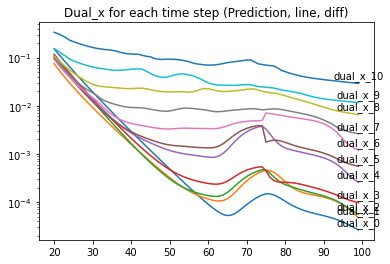

In [19]:
import math
rho_init = math.sqrt(traffic_dataset.graph_info['n_nodes'] / 24)
mu_init = 1
print('rho_init:', rho_init)
ADMM_info = {
    'rho': rho_init * 2,
    'rho_u': rho_init * 3,
    'rho_d': rho_init * 2,
    'mu_u': mu_init,
    'mu_d1':mu_init * 2,
    'mu_d2': mu_init
}
admm_block = ADMM_algorithm(traffic_dataset.graph_info,
                            ADMM_info,
                            use_kNN=True,
                            k=4,
                            u_sigma=50,
                            d_sigma=50,
                            use_line_graph=True,
                            t_in=11,
                            T=23
                            )
diff_x_pred = admm_block.combined_loop(diff_y)
admm_block.plot_residual(descriptions='Prediction, line, diff', log_y=True)
admm_block.plot_x_per_step(descriptions='Prediction, line, diff', log_y=False)
admm_block.plot_x_per_step(descriptions='Prediction, line, diff', log_y=True)
admm_block.plot_x_per_step(descriptions='Prediction, line, diff', log_y=True, show_list=range(12, 23), start_iters=20)
admm_block.plot_x_per_step(descriptions='Prediction, line, diff', log_y=True, show_list=range(11), start_iters=20)